# CIFAR-10 Classifier: TensorFlow 2.x Edition

## Objective

Build a simple CIFAR10 classification model that runs on **GPU** using following:
- Resnet 50 as backbone
- Tensorflow Datasets
- Minimal augmentation
- Experiment tracking using Comet ML

## Expected Outcome
By the end of this post, you will be able to:
- use backbone (VGG,EfficientNet,ResNext...) of your choice
- use the dataset of your choice or the ones available on tensorflow datasets
- use Comet ML in your projects

---
Date: 13-Aug-2020 | Author: Katnoria

# 1. Setup Imports

In [1]:
import os
import matplotlib.pyplot as plt
from time import time
from datetime import datetime

# load from .env
from pathlib import Path
from dotenv import load_dotenv

import comet_ml as cml
from comet_ml import Experiment

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model

In [2]:
# Load secrets
%load_ext dotenv
%dotenv ../../.env

In [3]:
COMET_ML_API_KEY = os.getenv("COMET_ML_API_KEY")
len(COMET_ML_API_KEY)

25

In [4]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [5]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)
version_info(cml)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1
comet_ml: 3.2.0


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# 2. Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [8]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [9]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

In [10]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [11]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [12]:
IMG_SIZE = 32
BATCH_SIZE = 128

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [13]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [14]:
example = train_ds.take(1)

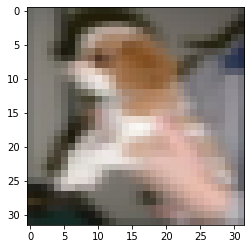

In [15]:
for images, labels in example:
    plt.imshow(images[0])

### Evaluation Pipeline

In [16]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [17]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

# Resnet50

Load the pre-trained model and set trainable to False. We could unfreeze last few layers and train on our dataset to improve the performance but this notebook does not cover that.

In [18]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

# Data Augmentation

Perform minimal augmentation

In [37]:
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

We will now create our first model

In [19]:
def get_pretrained_model(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [20]:
resnet_model_v2 = get_pretrained_model(base_model)
resnet_model_v2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

Set up the callbacks and compile 

In [21]:
lr = 1e-3

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
# Before we do any training, let's see the eval accuracy
resnet_model_v2.evaluate(test_ds)

78/78 [==============================] - 1s 11ms/step - loss: 5.7565 - accuracy: 0.1190


[5.756458759307861, 0.11899038404226303]

Ok, close to 12% which seems fair given that we have 10 Classes

## Comet ML

I am using [comet](https://www.comet.ml) to track experiments in this notebook. They have free plan for personal projects. You can also use W&B or just tensorboard as well 😀

In [23]:
experiment = Experiment(api_key=COMET_ML_API_KEY,
                        project_name="cf10-tensorflow", workspace="katnoria")
# add a relevant tag
experiment.add_tag("R50+GAP+Drop+Dense")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/katnoria/cf10-tensorflow/337552d900064aaf9a749c778d15425b



## Training

We will begin the training. You should be able to view your training progress and plots directly on the comet.ml page. 

In [25]:
# We are going to train for 50 epochs
EPOCHS=50

# track training time
training_start = time()
    
with experiment.train():

    history = resnet_model_v2.fit(
        train_ds, epochs=EPOCHS, validation_data=test_ds, 
        verbose=0, callbacks=[reduce_lr]
    )
stop = time()    

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


In [28]:
took = stop - training_start
print(f"Total training time: {took//60 : .0f}m {took%60:.0f}s")

Total training time:  4m 29s


In [29]:
params = {
    "batch_size": BATCH_SIZE,
    "learning_rate": lr,
    "epochs": EPOCHS
}

In [30]:
experiment.log_parameters(params)

In [31]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-tensorflow/337552d900064aaf9a749c778d15425b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [50]           : (0.5164663195610046, 0.6308693885803223)
COMET INFO:     train_batch_accuracy [1950]   : (0.15625, 0.7578125)
COMET INFO:     train_batch_loss [1950]       : (0.8148357272148132, 6.917840003967285)
COMET INFO:     train_epoch_duration [50]     : (5.244911544001297, 7.3150146400002996)
COMET INFO:     train_loss [50]               : (1.1530202627182007, 2.0462303161621094)
COMET INFO:     train_lr [50]                 : 0.0010000000474974513
COMET INFO:     train_val_accuracy [50]       : (0.6290063858032227, 0.6499398946762085)
COMET INFO:     train_val_loss [50]           : (1.0803184509277344, 1.1849

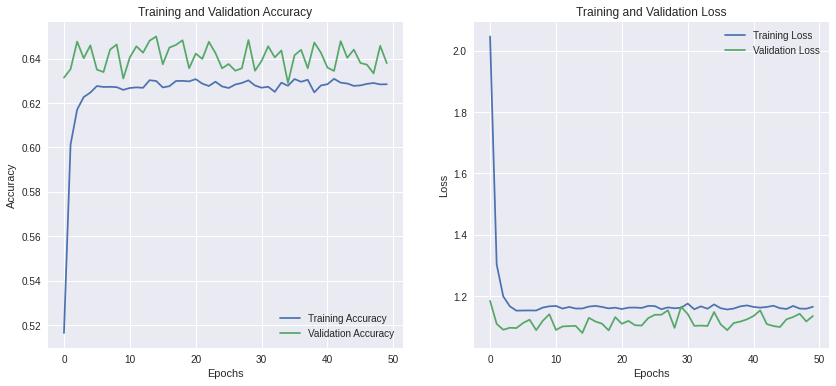

In [32]:
plot_history(history)

# Increase the network depth

If we notice the training accuracy, we see that we not not overfitting which probably means our network capacity is not enough. Let's now try to increase linear layers.

In [38]:
def get_pretrained_model_v4(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
#     x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)        
    x = Dropout(0.7)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [39]:
resnet_model_v4 = get_pretrained_model_v4(base_model, transforms)
resnet_model_v4.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [40]:
experiment = Experiment(api_key="r3QI6mx4KaB3v0VMFwt6bcf33",
                        project_name="cf10-tensorflow", workspace="katnoria")
# add a tag
experiment.add_tag("R50+Dense+Drop+Dense")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-tensorflow/b2e9255534c248d0b4dca900774d17b1
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (109 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     os packages              : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/katnoria/cf10-tensorflow/dff7abcfe189463486e3cddf17271abc



In [41]:
lr = 1e-3

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v4.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [42]:
# We are going to train for 50 epochs
EPOCHS=50
start = time()
print(f"start: {datetime.fromtimestamp(start)}")

with experiment.train():
    history = resnet_model_v4.fit(
        train_ds, epochs=EPOCHS, validation_data=test_ds, 
        verbose=0, callbacks=[reduce_lr]
    )
stop = time()    

start: 2020-10-15 12:27:08.489369


In [43]:
took = stop - start
print(f"Total training time: {took//60 : .0f}m {took%60:.0f}s")

Total training time:  4m 32s


In [44]:
params = {
    "batch_size": BATCH_SIZE,
    "learning_rate": lr,
    "epochs": EPOCHS
}
experiment.log_parameters(params)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-tensorflow/dff7abcfe189463486e3cddf17271abc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [50]           : (0.45122194290161133, 0.7407852411270142)
COMET INFO:     train_batch_accuracy [1950]   : (0.078125, 0.7734375)
COMET INFO:     train_batch_loss [1950]       : (0.5397055149078369, 8.377643585205078)
COMET INFO:     train_epoch_duration [50]     : (5.305807273000028, 7.86629192700093)
COMET INFO:     train_loss [50]               : (0.6816983819007874, 1.6903908252716064)
COMET INFO:     train_lr [50]                 : 0.0010000000474974513
COMET INFO:     train_val_accuracy [50]       : (0.5969551205635071, 0.6849960088729858)
COMET INFO:     train_val_loss [50]           : (0.941178560256958, 1.14262

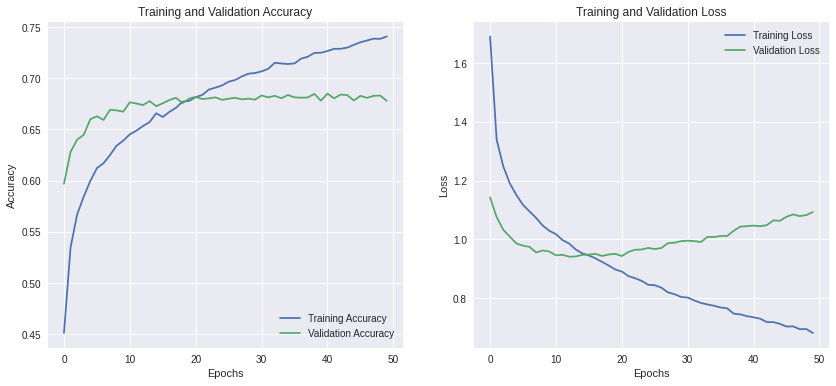

In [45]:
plot_history(history)

In [46]:
# Again, validation accuracy is recorded in Comet but we can print it out here too
resnet_model_v4.evaluate(test_ds)

78/78 [==============================] - 1s 12ms/step - loss: 1.0931 - accuracy: 0.6779


[1.0930745601654053, 0.6778846383094788]

# Next Steps

This is a very simple example of training CIFAR10 classifier using a pre-trained network. Its your turn to turn the knobs and see if you can get model to generalise better. Some ideas:

- make the model overfit your training data
- then regularize the model to generalize better 😉
- increase/decrease model capacity based on what you find in above steps
- add image augmentation
- use hyperparameter tuning library to find the best set of combination
- rollout your own model from scratch, you can use the tuning library to help design the network

---

So we got 67.8%. The state of the art model, at the time of writing this notebook, is **99.4%** by [Big Transfer (BiT-L) Paper](https://arxiv.org/abs/1912.11370v3). How's that for the motivation 💪🏽.

Paper Abstract:
> Transfer of pre-trained representations improves sample efficiency and simplifies hyperparameter tuning when training deep neural networks for vision. We revisit the paradigm of pre-training on large supervised datasets and fine-tuning the model on a target task. We scale up pre-training, and propose a simple recipe that we call Big Transfer (BiT). By combining a few carefully selected components, and transferring using a simple heuristic, we achieve strong performance on over 20 datasets. BiT performs well across a surprisingly wide range of data regimes -- from 1 example per class to 1M total examples. BiT achieves 87.5% top-1 accuracy on ILSVRC-2012, 99.4% on CIFAR-10, and 76.3% on the 19 task Visual Task Adaptation Benchmark (VTAB). On small datasets, BiT attains 76.8% on ILSVRC-2012 with 10 examples per class, and 97.0% on CIFAR-10 with 10 examples per class. We conduct detailed analysis of the main components that lead to high transfer performance.